In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy

# Create a dataset iterator

In [2]:
image_generator = ImageDataGenerator(
    validation_split=0.15,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=5
)
train_generator = image_generator.flow_from_directory("dataset", subset="training", target_size=(224,224), batch_size=8)
validation_generator = image_generator.flow_from_directory("dataset", subset="validation", target_size=(224,224), batch_size=8)

Found 454 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


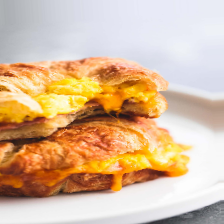

In [3]:
Image.fromarray(next(train_generator)[0][0].astype(numpy.uint8))

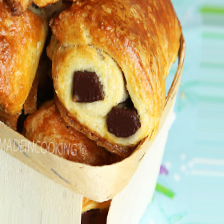

In [4]:
Image.fromarray(next(validation_generator)[0][0].astype(numpy.uint8))

# Create model
We're using a MobileNetV2 as we want to deploy on mobile.

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *


In [6]:
mobile = MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet', 
    pooling='avg',
    alpha=0.5
)
output = Dropout(0.4)(mobile.output)
output = Dense(8, activation="relu")(output)
output = Dense(2, activation='softmax')(output)

model = Model(inputs=mobile.input, outputs=output)
model.summary()

5578752/5577668 [==============================] - 4s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 16)      432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 16)      64        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 16)      144       
_________________________________________________________________
conv_dw_1_bn 

In [7]:
model.compile(optimizer=Adam(amsgrad=True), loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
callbacks = [
    ReduceLROnPlateau(
        patience=3,
        factor=0.2,
        verbose=1,
        min_lr=1e-5
    ),
    ModelCheckpoint(
        filepath="croissant.hdf5",
        verbose=1,
        save_best_only=True
    )
]

In [9]:
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=256,
    epochs=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=40,
    callbacks=callbacks
)

Epoch 1/50


/home/pierre/Development/Devoxx/venv/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


255/256 [============================>.] - ETA: 0s - loss: 0.3739 - acc: 0.8392
Epoch 00001: val_loss improved from inf to 0.38563, saving model to croissant.hdf5
256/256 [==============================] - 47s 182ms/step - loss: 0.3729 - acc: 0.8398 - val_loss: 0.3856 - val_acc: 0.8576
Epoch 2/50
255/256 [============================>.] - ETA: 0s - loss: 0.2256 - acc: 0.9211
Epoch 00002: val_loss improved from 0.38563 to 0.29668, saving model to croissant.hdf5
256/256 [==============================] - 41s 161ms/step - loss: 0.2295 - acc: 0.9194 - val_loss: 0.2967 - val_acc: 0.8829
Epoch 3/50
255/256 [============================>.] - ETA: 0s - loss: 0.1816 - acc: 0.9297
Epoch 00003: val_loss improved from 0.29668 to 0.26838, saving model to croissant.hdf5
256/256 [==============================] - 42s 164ms/step - loss: 0.1810 - acc: 0.9300 - val_loss: 0.2684 - val_acc: 0.9146
Epoch 4/50
255/256 [============================>.] - ETA: 0s - loss: 0.1264 - acc: 0.9559
Epoch 00004: val_l

KeyboardInterrupt: 